# 트랜스포머를 이용한 주가 방향성 예측 모델 만들기

In [5]:
!pip install yfinance

In [6]:
# RSI 지표등 금융 시계열에서 사용하는 지표를 자동으로 계산
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=cd21470f8202da10c3ad383132d4eb580c03c1de6054d2a3040a886fa966c50a
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [7]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.9 MB/s eta 0:00:00


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import koreanize_matplotlib
import seaborn as sns
import tensorflow as tf

* 애플(AAPL)의 2013년 ~ 2023년까지 수집 후 훈련데이터로 사용
* 2024년 1월부터 4월까지 데이터를 테스트 데이터로 사용
* 금융데이터에서 1달은 = 21일, 1년 = 252일 정도임

In [9]:
# end + 1 날짜로 해야됨
train = yf.download('AAPL', start='2013-01-01', end='2024-01-01')
test = yf.download('AAPL', start='2024-01-01', end='2024-05-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
train

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.705702,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.494839,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.035381,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.941054,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,15.983954,458707200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320206,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700


In [11]:
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,184.938217,82488700
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.553467,58414500
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.222336,71983600
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.495071,62303300
2024-01-08,182.089996,185.600006,181.500000,185.559998,184.858521,59144500
...,...,...,...,...,...,...
2024-04-24,166.539993,169.300003,166.210007,169.020004,168.595917,48251800
2024-04-25,169.529999,170.610001,168.149994,169.889999,169.463730,50558300
2024-04-26,169.880005,171.339996,169.179993,169.300003,168.875214,44838400


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2013-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2768 non-null   float64
 1   High       2768 non-null   float64
 2   Low        2768 non-null   float64
 3   Close      2768 non-null   float64
 4   Adj Close  2768 non-null   float64
 5   Volume     2768 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 151.4 KB


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

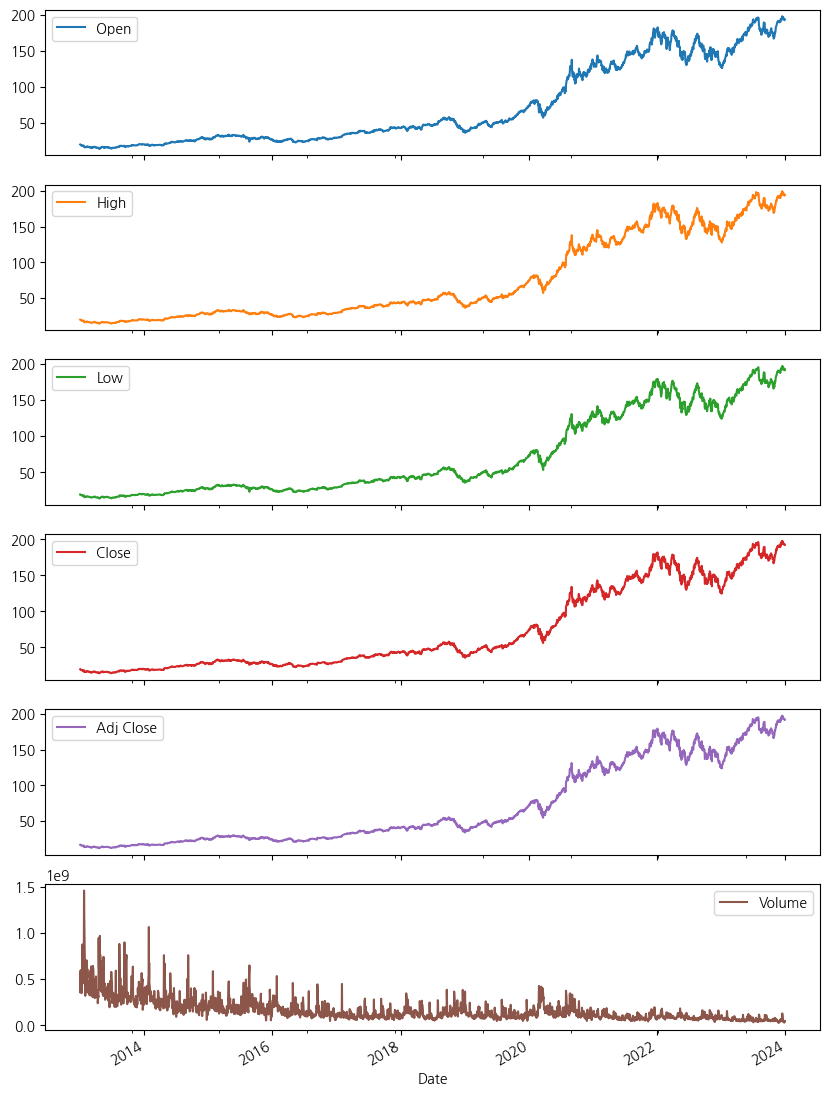

In [13]:
train.plot(figsize=(10, 15), subplots=True)

 ### SMA14, VMA14, RSI_14

In [14]:
train['sma_14'] = train['Close'].rolling(window=14).mean()

In [15]:
train

,Open,High,Low,Close,Adj Close,Volume,sma_14
Date,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.705702,560518000,NaN
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.494839,352965200,NaN
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.035381,594333600,NaN
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.941054,484156400,NaN
2013-01-08,18.900356,18.996071,18.616072,18.761070,15.983954,458707200,NaN
...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,195.227859
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320206,28919300,195.201431
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700,195.260716


In [16]:
test['sma_14'] = train['Close'].rolling(window=14).mean()

In [17]:

test

,Open,High,Low,Close,Adj Close,Volume,sma_14
Date,,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,184.938217,82488700,NaN
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.553467,58414500,NaN
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.222336,71983600,NaN
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.495071,62303300,NaN
2024-01-08,182.089996,185.600006,181.500000,185.559998,184.858521,59144500,NaN
...,...,...,...,...,...,...,...
2024-04-24,166.539993,169.300003,166.210007,169.020004,168.595917,48251800,NaN
2024-04-25,169.529999,170.610001,168.149994,169.889999,169.463730,50558300,NaN
2024-04-26,169.880005,171.339996,169.179993,169.300003,168.875214,44838400,NaN


In [18]:
train['vma_14'] = train['Volume'].rolling(window=14).mean()
test['vma_14'] = train['Volume'].rolling(window=14).mean()

In [19]:
test

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14
Date,,,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,184.938217,82488700,NaN,NaN
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.553467,58414500,NaN,NaN
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.222336,71983600,NaN,NaN
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.495071,62303300,NaN,NaN
2024-01-08,182.089996,185.600006,181.500000,185.559998,184.858521,59144500,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-04-24,166.539993,169.300003,166.210007,169.020004,168.595917,48251800,NaN,NaN
2024-04-25,169.529999,170.610001,168.149994,169.889999,169.463730,50558300,NaN,NaN
2024-04-26,169.880005,171.339996,169.179993,169.300003,168.875214,44838400,NaN,NaN


In [20]:
train['rsi_14'] = ta.momentum.RSIIndicator(train['Close']).rsi()
test['rsi_14'] = ta.momentum.RSIIndicator(train['Close']).rsi()

In [21]:
train.head(20)

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14
Date,,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.705702,560518000,NaN,NaN,NaN
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.494839,352965200,NaN,NaN,NaN
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.035381,594333600,NaN,NaN,NaN
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.941054,484156400,NaN,NaN,NaN
2013-01-08,18.900356,18.996071,18.616072,18.761070,15.983954,458707200,NaN,NaN,NaN
2013-01-09,18.660713,18.750357,18.428213,18.467857,15.734145,407604400,NaN,NaN,NaN
2013-01-10,18.876785,18.882856,18.411428,18.696787,15.929187,601146000,NaN,NaN,NaN
2013-01-11,18.607143,18.761429,18.536428,18.582144,15.831514,350506800,NaN,NaN,NaN
2013-01-14,17.952856,18.125000,17.803928,17.919643,15.267079,734207600,NaN,NaN,NaN


In [22]:
train = train.dropna()
test = test.dropna()

In [23]:
train['pct_change'] = train['Close'].pct_change()
test['pct_change'] = test['Close'].pct_change()

<ipython-input-23-e0e405fe5a6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pct_change'] = train['Close'].pct_change()


In [24]:
train['pct_change'].describe()

,pct_change
count,2754.000000
mean,0.001020
std,0.017870
min,-0.128647
25%,-0.007406
50%,0.000889
75%,0.010222
max,0.119808


In [25]:
# 0.000889이상이면 1을 주고 아니면 0을 줘라
train['target']=np.where(train['pct_change'] > 0.000889, 1, 0)
test['target']=np.where(test['pct_change'] > 0.000889, 1, 0)

<ipython-input-25-f834be7af6e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target']=np.where(train['pct_change'] > 0.000889, 1, 0)


In [26]:
train

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14,pct_change,target
Date,,,,,,,,,,,
2013-01-22,18.020000,18.138571,17.736786,18.027500,15.358974,461546400,18.442500,5.357050e+08,34.843050,NaN,0
2013-01-23,18.171785,18.392500,18.027500,18.357500,15.640127,861509600,18.353163,5.572044e+08,42.653035,0.018305,1
2013-01-24,16.428572,16.633215,16.080357,16.089287,13.707664,1460852400,18.119490,6.363392e+08,22.600673,-0.123558,0
2013-01-25,16.131786,16.293928,15.535714,15.710000,13.384521,1208026400,17.897245,6.801744e+08,20.836621,-0.023574,0
2013-01-28,15.636786,16.186071,15.566429,16.065357,13.687276,785517600,17.708291,7.017002e+08,26.615905,0.022620,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,195.227859,5.857288e+07,54.609714,-0.005547,0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320206,28919300,195.201431,5.587937e+07,53.026883,-0.002841,0
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700,195.260716,5.637923e+07,53.291938,0.000518,0


In [27]:
train = train.dropna()
test = test.dropna()

In [28]:
train['target'] = train['target'].shift(-1)
test['target'] = test['target'].shift(-1)

<ipython-input-28-4d646fa3db7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = train['target'].shift(-1)


In [29]:
train = train.dropna()
test = test.dropna()

In [30]:
train

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14,pct_change,target
Date,,,,,,,,,,,
2013-01-23,18.171785,18.392500,18.027500,18.357500,15.640127,861509600,18.353163,5.572044e+08,42.653035,0.018305,0.0
2013-01-24,16.428572,16.633215,16.080357,16.089287,13.707664,1460852400,18.119490,6.363392e+08,22.600673,-0.123558,0.0
2013-01-25,16.131786,16.293928,15.535714,15.710000,13.384521,1208026400,17.897245,6.801744e+08,20.836621,-0.023574,1.0
2013-01-28,15.636786,16.186071,15.566429,16.065357,13.687276,785517600,17.708291,7.017002e+08,26.615905,0.022620,1.0
2013-01-29,16.375000,16.435715,16.147142,16.366785,13.944089,571158000,17.537271,7.097324e+08,31.203836,0.018763,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,193.944031,46482500,194.930001,5.902050e+07,57.752982,-0.000770,0.0
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,195.227859,5.857288e+07,54.609714,-0.005547,0.0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320206,28919300,195.201431,5.587937e+07,53.026883,-0.002841,0.0


In [31]:
X = train.drop(['target'], axis=1)
y = train['target']

In [32]:
X

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14,pct_change
Date,,,,,,,,,,
2013-01-23,18.171785,18.392500,18.027500,18.357500,15.640127,861509600,18.353163,5.572044e+08,42.653035,0.018305
2013-01-24,16.428572,16.633215,16.080357,16.089287,13.707664,1460852400,18.119490,6.363392e+08,22.600673,-0.123558
2013-01-25,16.131786,16.293928,15.535714,15.710000,13.384521,1208026400,17.897245,6.801744e+08,20.836621,-0.023574
2013-01-28,15.636786,16.186071,15.566429,16.065357,13.687276,785517600,17.708291,7.017002e+08,26.615905,0.022620
2013-01-29,16.375000,16.435715,16.147142,16.366785,13.944089,571158000,17.537271,7.097324e+08,31.203836,0.018763
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,193.944031,46482500,194.930001,5.902050e+07,57.752982,-0.000770
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,195.227859,5.857288e+07,54.609714,-0.005547
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320206,28919300,195.201431,5.587937e+07,53.026883,-0.002841


In [33]:
y.value_counts()

,count
target,
0.0,1377
1.0,1376


## 데이터 정규화

<Axes: >

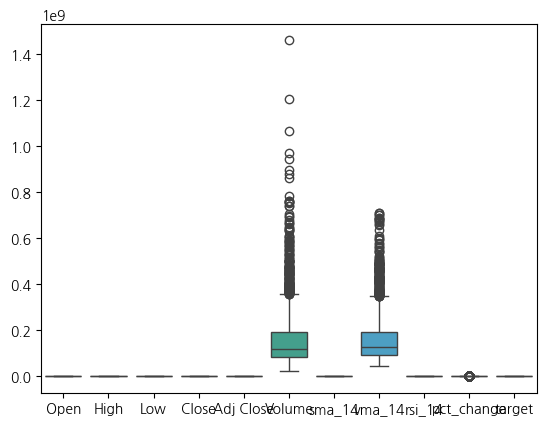

In [34]:
sns.boxplot(train)

In [35]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [36]:
rs = RobustScaler()
mms = MinMaxScaler()
X_rs_scaled = rs.fit_transform(X.copy())
X_mms_scaled = mms.fit_transform(X.copy())

In [37]:
from sklearn.model_selection import train_test_split


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_rs_scaled, y, shuffle=False, test_size=0.3, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_mms_scaled, y, shuffle=False, test_size=0.3, random_state=10)

# 트랜스포머 모델 정의

In [39]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [40]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  # 멀티헤드 어텐션
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
  x = LayerNormalization(epsilon=1e-6)(x)
  res = x + inputs

  # 피드포워드 네트워크
  x = Dense(ff_dim, activation='relu')(res)
  x = Dense(inputs.shape[-1])(x)
  x = LayerNormalization(epsilon=1e-6)(x)
  return x + res



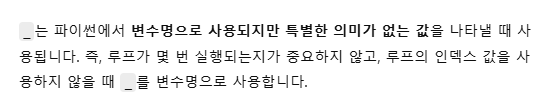

In [41]:
def bulid_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
  inputs = Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  x = Flatten()(x)
  for dim in mlp_units:
    x = Dense(dim, activation='relu')(x)
    x = Dropout(mlp_dropout)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  return Model(inputs, outputs)

In [42]:
# 모델 생성
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = bulid_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.25, mlp_dropout=0.1)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 10, 1)          │          7,169 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 10, 1)          │              2 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 1)          │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 4)          │              8 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10, 1)          │              5 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 10, 1)          │              2 │ dense_1[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 10, 1)          │          7,169 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10, 4)          │              8 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10, 1)          │              5 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 10, 1)          │              2 │ dense_3[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_3… │
│                      

 Total params: 30,281 (118.29 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - accuracy: 0.5000 - loss: 0.7065 - val_accuracy: 0.4903 - val_loss: 0.7252
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5126 - loss: 0.7060 - val_accuracy: 0.4879 - val_loss: 0.7227
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5095 - loss: 0.7033 - val_accuracy: 0.4879 - val_loss: 0.7212
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4996 - loss: 0.6997 - val_accuracy: 0.4867 - val_loss: 0.7194
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5034 - loss: 0.6965 - val_accuracy: 0.4891 - val_loss: 0.7189
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5223 - loss: 0.6933 - val_accuracy: 0.4891 - val_loss: 0.7180
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5022 - loss: 0.6979 - val_accuracy: 0.4952 - val_loss: 0.7153
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4908 - loss: 0.6985 - val_accuracy: 0.4952 

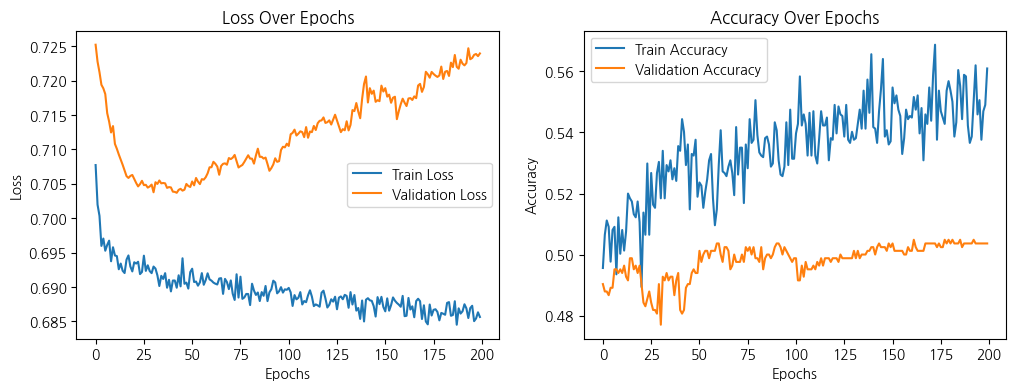

In [43]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test],
                    epochs=200, batch_size=32)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
# 모델 생성
input_shape = (X2_train.shape[1], 1)
X2_train = X2_train.reshape((X2_train.shape[0], X2_train.shape[1], 1))
X2_test = X2_test.reshape((X2_test.shape[0], X2_test.shape[1], 1))

model = bulid_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.25, mlp_dropout=0.1)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 10, 1)          │          7,169 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_8… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 10, 4)          │              8 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 10, 1)          │              5 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 10, 1)          │              2 │ dense_11[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_9… │
│                           │                        │                │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 10, 1)          │          7,169 │ add_9[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 10, 1)          │              0 │ layer_normalization_1… │
│                           │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 10, 4)          │              8 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 10, 1)          │              5 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 10, 1)          │              2 │ dense_13[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)         

 Total params: 30,281 (118.29 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.5027 - loss: 0.6939 - val_accuracy: 0.5291 - val_loss: 0.6929
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5053 - loss: 0.6933 - val_accuracy: 0.5121 - val_loss: 0.6929
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4936 - loss: 0.6934 - val_accuracy: 0.5218 - val_loss: 0.6930
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5093 - loss: 0.6933 - val_accuracy: 0.5073 - val_loss: 0.6929
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4859 - loss: 0.6935 - val_accuracy: 0.5048 - val_loss: 0.6929
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5047 - loss: 0.6936 - val_accuracy: 0.5036 - val_loss: 0.6930
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5151 - loss: 0.6928 - val_accuracy: 0.5048 - val_loss: 0.6931
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5007 - loss: 0.6935 - val_accuracy: 0.521

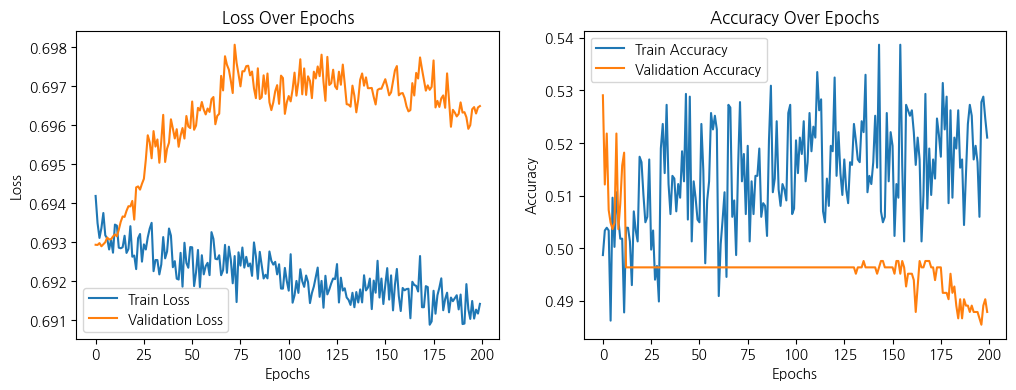

In [45]:
history = model.fit(X2_train, y2_train, validation_data=[X2_test, y2_test],
                    epochs=200, batch_size=32)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [48]:
# ModelCheckpoint 설정
checkpoint_filepath = 'best_model.keras'  # 파일 경로를 .keras 확장자로 변경
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss',  # 'val_loss'가 가장 좋은 모델 저장
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

In [50]:
# 모델 생성
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = bulid_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.25, mlp_dropout=0.1)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 10, 1)          │          7,169 │ input_layer_3[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 10, 1)          │              0 │ layer_normalization_2… │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 10, 4)          │              8 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 10, 1)          │              5 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, 10, 1)          │              2 │ dense_31[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 10, 1)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 10, 1)          │          7,169 │ add_25[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 10, 1)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 10, 4)          │              8 │ add_26[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 10, 1)          │              5 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_27    │ (None, 10, 1)          │              2 │ dense_33[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)         

 Total params: 30,281 (118.29 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# 학습 과정에서 가장 좋은 모델을 저장
history = model.fit(X_train, y_train, validation_data=[X_test, y_test],
                    epochs=200, batch_size=32, callbacks=[checkpoint])

# 저장된 가장 좋은 모델을 불러오기
best_model = tf.keras.models.load_model(checkpoint_filepath)

# 저장된 모델로 성능 평가
best_model.evaluate(X_test, y_test)

Epoch 1/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5642 - loss: 0.6843
Epoch 1: val_loss did not improve from 0.69329
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5629 - loss: 0.6844 - val_accuracy: 0.5073 - val_loss: 0.7200
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5552 - loss: 0.6821
Epoch 2: val_loss did not improve from 0.69329
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5553 - loss: 0.6821 - val_accuracy: 0.5085 - val_loss: 0.7200
Epoch 3/200
51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5509 - loss: 0.6823
Epoch 3: val_loss did not improve from 0.69329
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5496 - loss: 0.6826 - val_accuracy: 0.5085 - val_loss: 0.7197
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5306 - loss: 0.6906
Epoch 4: val_loss did not improve from 0.69329
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5309 - loss: 0.6906 - val_accuracy: 0.5085 - val_loss: 0.7195
Epoch 5/200


[0.6932883858680725, 0.5036319494247437]

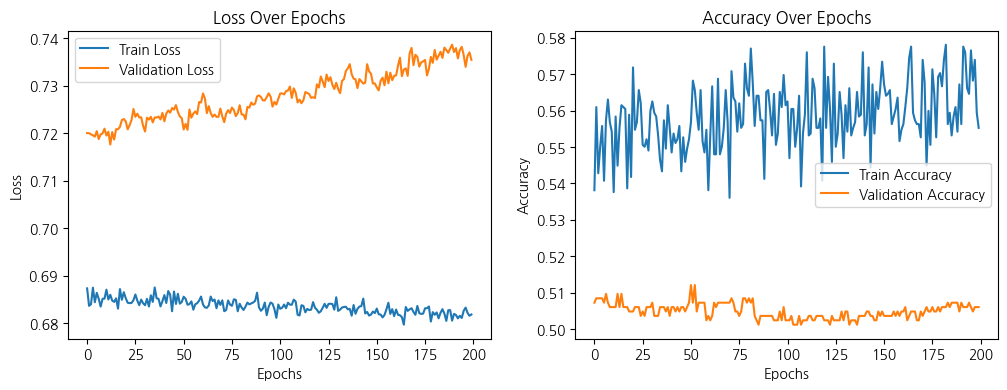

In [54]:
# 학습 그래프 출력
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import classification_report, accuracy_score

# 예측값 생성 (예시로 X_test를 모델에 통과시켜 예측값을 생성)
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # 시그모이드 출력을 0 또는 1로 변환

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# 분류 리포트 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step
Accuracy: 0.5036319612590799
Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.74      0.60       416
         1.0       0.50      0.27      0.35       410

    accuracy                           0.50       826
   macro avg       0.50      0.50      0.47       826
weighted avg       0.50      0.50      0.47       826



In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('best_model.keras')

In [ ]:
test_X_robust = rs.tranform(test_X.copy())
test_X_mmst = mms.tranform(test_X.copy())